In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
from tensorflow.keras.optimizers import Adam

# Data preparation

In [3]:
data_path = "/Users/wilkie/data/smart_pixels_13/resampled/"

In [4]:
pq1 = pd.read_parquet(data_path + "pixels.parquet")

In [5]:
def take_yprofile(data):
    data = np.array(data)
    #reshape to 2D
    data = np.reshape(data, (13, 21))
    #take the y-profile
    profile = np.sum(data, axis=1)
    return profile


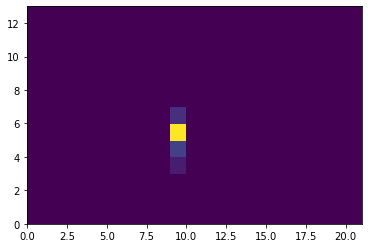

In [6]:
arr = np.array(pq1.iloc[0])
plt.pcolor(np.reshape(arr, (13, 21)))

In [7]:
prof = take_yprofile(pq1.iloc[0])

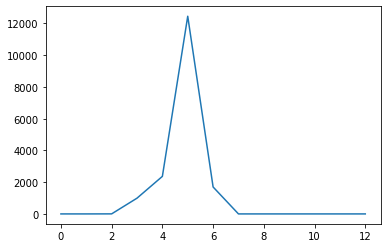

In [8]:
plt.plot(prof)

In [9]:
pq1_truth = pd.read_parquet(data_path + "truth.parquet")

In [10]:
pq1_truth

,x-entry,y-entry,z-entry,n_x,n_y,n_z,number_eh_pairs,y-local,pt,cotAlpha,cotBeta,y-midplane,x-midplane
0,-48.731285,2.872706,100.0,-0.239328,-0.141072,-1.238494,17510.0,-3.83818,-1.2465,0.193241,0.113906,-2.822598,-58.393342
1,-175.338928,25.938915,100.0,0.809492,-0.089265,-0.325481,17308.0,-6.57575,0.3375,-2.487064,0.274256,12.226133,-50.985740
2,177.558731,9.934172,100.0,-0.312144,-0.010484,-0.115023,43849.0,-7.47091,-0.1155,2.713753,0.091147,5.376823,41.871086
3,-418.620941,-10.610765,100.0,6.665171,-0.050723,-0.797890,66669.0,-2.55476,-0.7995,-8.353496,0.063571,-13.789336,-0.946136
4,-346.192657,0.553267,100.0,5.683409,-0.086886,-1.020810,51912.0,-2.04856,1.0245,-5.567548,0.085115,-3.702471,-67.815241
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142441,-244.353317,-21.291264,100.0,4.772877,0.171492,-0.993811,38561.0,5.71171,1.0085,-4.802600,-0.172560,-12.663265,-4.223302
142442,106.646729,-6.055300,100.0,-2.420932,-0.238303,-1.075415,18785.0,-7.15189,-1.1015,2.251161,0.221592,-17.134883,-5.911307
142443,278.253296,8.187221,100.0,-7.997903,-0.240937,-1.211780,89705.0,-6.40753,-1.2355,6.600128,0.198829,-1.754229,-51.753100
142444,428.472778,20.989643,100.0,-16.716227,-0.146345,-2.062316,62892.0,-1.87912,2.0675,8.105560,0.070961,17.441569,23.194756


In [11]:
def get_training(charge_file, truth_file):
    xs = []
    ys = []

    for idx, row in charge_file.iterrows():
        profile = take_yprofile(row)
        truth = truth_file.iloc[idx]
        y_local = np.array(truth["y-local"])
        pt = np.array(truth["pt"])

        x = np.concatenate((profile, [y_local]))
        y = pt

        xs.append(x)
        ys.append(y)
    
    return np.array(xs), np.array(ys)

        

In [12]:
prof, pt = get_training(pq1, pq1_truth)

In [13]:
cutoff = 80000

In [15]:
X_train = prof[0:cutoff, :]
y_pt_train = pt[0:cutoff]

In [16]:
X_train.shape

(80000, 14)

In [17]:
y_pt_train.shape

(80000,)

In [17]:
#original is 652,160 samples

In [19]:
X_test = prof[cutoff:, :]
y_pt_test = pt[cutoff:]

In [20]:
X_test.shape

(62446, 14)

In [21]:
y_pt_test.shape

(62446,)

(array([7059., 7871., 8277., 8430., 8306., 8291., 8452., 8276., 7959.,
        7079.]),
 array([-2.0995, -1.6796, -1.2597, -0.8398, -0.4199,  0.    ,  0.4199,
         0.8398,  1.2597,  1.6796,  2.0995]),
 <BarContainer object of 10 artists>)

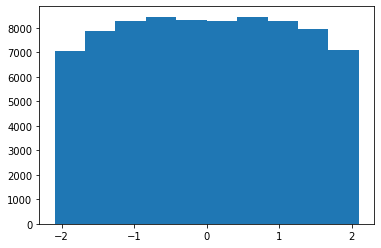

In [27]:
plt.hist(y_pt_train)

In [22]:
def get_truth(momenta, threshold):
    return 1.0 * (momenta > threshold) + 2.0 * (momenta < -1 * threshold)

In [23]:
threshold = 0.2

In [24]:
y_train = get_truth(y_pt_train, threshold)

In [25]:
y_test = get_truth(y_pt_test, threshold)

(array([ 8293.,     0.,     0.,     0.,     0., 35905.,     0.,     0.,
            0., 35802.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

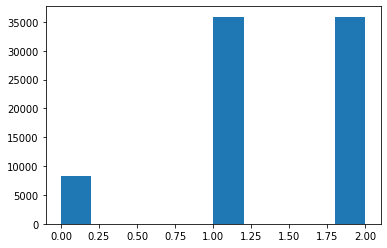

In [26]:
plt.hist(y_train)

In [28]:
#original is 3,597,877 test samples

# Training

In [28]:
# X_train = df1.values
# X_test = df3.values

# y_train = df2.values
# y_test = df4.values
# #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(80000, 14) (62446, 14) (80000,) (62446,)


In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [30]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(14,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 128)               1920      
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,307
Trainable params: 2,307
Non-trainable params: 0
_________________________________________________________________


In [31]:
es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=20,
                                   restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=200, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)



Epoch 1/200
63/63 [==============================] - 1s 11ms/step - loss: 0.9801 - sparse_categorical_accuracy: 0.4746 - val_loss: 0.9382 - val_sparse_categorical_accuracy: 0.4965
Epoch 2/200
63/63 [==============================] - 0s 8ms/step - loss: 0.9354 - sparse_categorical_accuracy: 0.5029 - val_loss: 0.9283 - val_sparse_categorical_accuracy: 0.5173
Epoch 3/200
63/63 [==============================] - 0s 7ms/step - loss: 0.9273 - sparse_categorical_accuracy: 0.5207 - val_loss: 0.9213 - val_sparse_categorical_accuracy: 0.5339
Epoch 4/200
63/63 [==============================] - 0s 7ms/step - loss: 0.9207 - sparse_categorical_accuracy: 0.5386 - val_loss: 0.9157 - val_sparse_categorical_accuracy: 0.5458
Epoch 5/200
63/63 [==============================] - 0s 7ms/step - loss: 0.9149 - sparse_categorical_accuracy: 0.5492 - val_loss: 0.9102 - val_sparse_categorical_accuracy: 0.5507
Epoch 6/200
63/63 [==============================] - 0s 7ms/step - loss: 0.9094 - sparse_categorical_acc

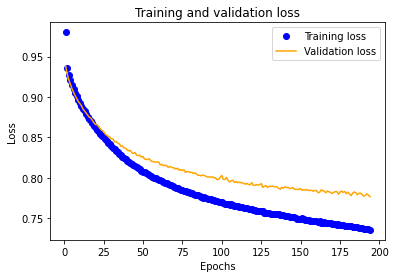

In [34]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')

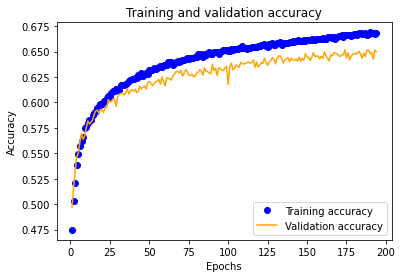

In [35]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#np.max(val_acc)
plt.savefig('accuracy.png')
plt.show()

In [36]:
preds = model.predict(X_test) 
predictionsFiles =np.argmax(preds, axis=1)

1952/1952 [==============================] - 3s 2ms/step


(array([ 3330.,     0.,     0.,     0.,     0., 31099.,     0.,     0.,
            0., 28017.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

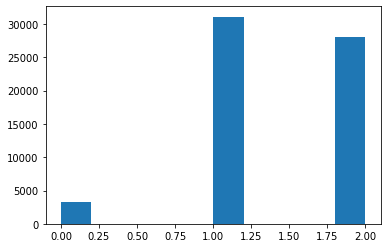

In [37]:
plt.hist(predictionsFiles)

In [38]:
#pd.DataFrame(predictionsFiles).to_csv("predictionsFiles.csv",header='predict', index=False)

In [39]:
#pd.DataFrame(y_test).to_csv("true.csv",header='true', index=False)

In [40]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.7708338499069214
Test accuracy: 0.6539409756660461


Confusion matrix:
[[ 2388  2184  1846]
 [  510 19879  7602]
 [  432  9036 18569]]


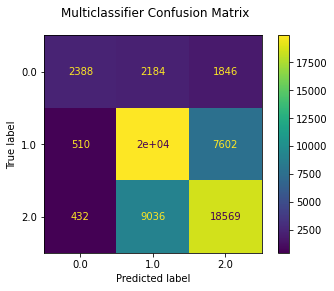

In [41]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('confusionMatrix.png')
plt.show()

# ROC curve

In [43]:
from sklearn.metrics import RocCurveDisplay

In [44]:
def ROC_OvR(preds, labels):
    classes = np.unique(labels)
    n_classes = len(classes)

    #go through each class to build a one-versus-rest ROC
    scores = []
    truth = []

    for c in range(1, n_classes):
        in_class = 1.0 *(labels == c)
        score = preds[:,c]

        scores.append(score)
        truth.append(in_class)

    scores = np.array(scores).ravel()
    truth = np.array(truth).ravel()

    return truth, scores


In [45]:
t, s = ROC_OvR(preds, y_test)

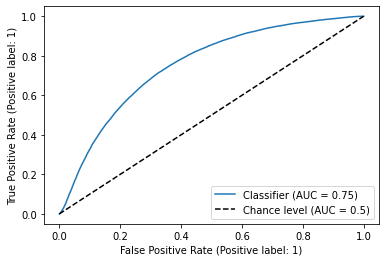

In [46]:
RocCurveDisplay.from_predictions(
    t,
    s,
    plot_chance_level=True
)

In [47]:
from sklearn.metrics import roc_auc_score

In [48]:
roc_auc_score(t, s)

0.7518921831973934

In [49]:
def test_roc_by_threshold(threshold):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(14,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer=Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
                metrics=[keras.metrics.SparseCategoricalAccuracy()])

    es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=20,
                                   restore_best_weights=True)

    y_train = get_truth(y_pt_train, threshold)
    y_test = get_truth(y_pt_test, threshold)

    history = model.fit(X_train,
                        y_train,
                        callbacks=[es],
                        epochs=200, 
                        batch_size=1024,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=1)

    preds = model.predict(X_test) 

    t, s = ROC_OvR(preds, y_test)
    roc_auc = roc_auc_score(t, s)

    result = {"history" : history,
            "model" : model,
            "roc_auc" : roc_auc,}

    return result


In [50]:
res = test_roc_by_threshold(0.1)

Epoch 1/200
63/63 [==============================] - 1s 11ms/step - loss: 0.8956 - sparse_categorical_accuracy: 0.5100 - val_loss: 0.8194 - val_sparse_categorical_accuracy: 0.5388
Epoch 2/200
63/63 [==============================] - 1s 8ms/step - loss: 0.8056 - sparse_categorical_accuracy: 0.5455 - val_loss: 0.7999 - val_sparse_categorical_accuracy: 0.5594
Epoch 3/200
63/63 [==============================] - 0s 8ms/step - loss: 0.7919 - sparse_categorical_accuracy: 0.5699 - val_loss: 0.7900 - val_sparse_categorical_accuracy: 0.5804
Epoch 4/200
63/63 [==============================] - 0s 8ms/step - loss: 0.7829 - sparse_categorical_accuracy: 0.5877 - val_loss: 0.7822 - val_sparse_categorical_accuracy: 0.5950
Epoch 5/200
63/63 [==============================] - 1s 8ms/step - loss: 0.7749 - sparse_categorical_accuracy: 0.6022 - val_loss: 0.7758 - val_sparse_categorical_accuracy: 0.6085
Epoch 6/200
63/63 [==============================] - 0s 8ms/step - loss: 0.7680 - sparse_categorical_acc

In [51]:
res

{'history': <keras.callbacks.History at 0x2aac33c40>,
 'model': <keras.engine.sequential.Sequential at 0x2aa37d6a0>,
 'roc_auc': 0.7877264792452963}

In [52]:
thresholds = np.linspace(0.1, 1.0, 10)

In [53]:
thresholds

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [54]:
res2 = [test_roc_by_threshold(t) for t in thresholds]

Epoch 1/200
63/63 [==============================] - 1s 11ms/step - loss: 0.8776 - sparse_categorical_accuracy: 0.5192 - val_loss: 0.8126 - val_sparse_categorical_accuracy: 0.5437
Epoch 2/200
63/63 [==============================] - 0s 8ms/step - loss: 0.8018 - sparse_categorical_accuracy: 0.5531 - val_loss: 0.7976 - val_sparse_categorical_accuracy: 0.5594
Epoch 3/200
63/63 [==============================] - 0s 7ms/step - loss: 0.7901 - sparse_categorical_accuracy: 0.5755 - val_loss: 0.7881 - val_sparse_categorical_accuracy: 0.5828
Epoch 4/200
63/63 [==============================] - 0s 7ms/step - loss: 0.7814 - sparse_categorical_accuracy: 0.5955 - val_loss: 0.7809 - val_sparse_categorical_accuracy: 0.5971
Epoch 5/200
63/63 [==============================] - 0s 7ms/step - loss: 0.7743 - sparse_categorical_accuracy: 0.6092 - val_loss: 0.7744 - val_sparse_categorical_accuracy: 0.6172
Epoch 6/200
63/63 [==============================] - 0s 7ms/step - loss: 0.7678 - sparse_categorical_acc

In [58]:
balanced_vals = np.array([r["roc_auc"] for r in res2])

In [59]:
balanced_vals

array([0.79580714, 0.74764243, 0.72229491, 0.69875351, 0.67919642,
       0.6619992 , 0.64317053, 0.62273766, 0.54205283, 0.5693443 ])

In [61]:
unbalanced_vals = np.array([0.86312258, 0.81111764, 0.77784263, 0.73018499, 0.62677491,
       0.57890733, 0.60992437, 0.57153878, 0.51216339])

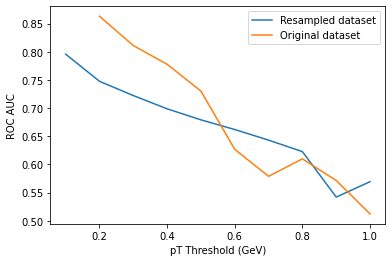

In [64]:
plt.plot(thresholds, balanced_vals, label="Resampled dataset")
plt.plot(thresholds[1:], unbalanced_vals, label="Original dataset")
plt.xlabel("pT Threshold (GeV)")
plt.ylabel("ROC AUC")
plt.legend()

Text(0, 0.5, 'ROC AUC')

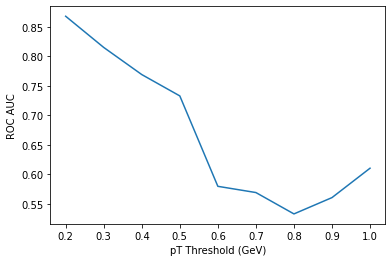

In [ ]:
plt.plot(thresholds, [r["roc_auc"] for r in res2])
plt.xlabel("pT Threshold (GeV)")
plt.ylabel("ROC AUC")

In [110]:
#model.save('my_model.keras')

In [111]:
#model.save('my_model.h5')

In [22]:
#loss, acc = new_model.evaluate(X_test, y_test, verbose=2)
#print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

112434/112434 - 87s - loss: 0.5151 - sparse_categorical_accuracy: 0.7878 - 87s/epoch - 778us/step
Restored model, accuracy: 78.78%
